In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import torchvision
from torchvision import  models, transforms
import matplotlib.pyplot as plt
import time
import os
from torch.optim import lr_scheduler
# Set seed
seed = 173
np.random.seed(seed)
torch.manual_seed(seed)


In [4]:
import pandas as pd
class CelebaCustomDataset(torch.utils.data.Dataset):
  def __init__(self, root,data, transforms):
        self.root = root
        self.transforms = transforms
        self.data = data 
        # load all image files
        self.imgs = os.listdir(os.path.join(self.root,self.data))
        
        #get the attribute file
        self.attribute_file = os.path.join(self.root, "list_attr_celeba.txt")
        self.attributes =pd.read_csv(self.attribute_file,delim_whitespace = True,skiprows = 1,index_col=0)# pd.read_csv(self.attribute_file , skiprows = 1,header=0,delimiter=' ',index_col=0)
        #print("a1",self.attributes.head() )
        #print(len(self.attributes.columns))

  def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root,self.data, self.imgs[idx])
        #print("path",img_path)
        img = Image.open(img_path).convert("RGB")
        #print("a",self.attributes.head())
        #read attributes
        attr = np.array(self.attributes.loc[self.imgs[idx]].tolist())
        attr = attr+1
        attr = (attr/2).astype(int)
        #print(attr)

        if self.transforms is not None:
            img = self.transforms(img)

        #print("return")
        return img, attr

  def __len__(self):
        return len(self.imgs)

In [5]:


image_size = 256
batch_size = 32 #24
dataroot = "/content/drive/MyDrive/Jio"
data = "train"
dataset_train = CelebaCustomDataset(root=dataroot,data=data,
                           transforms=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                         shuffle=True, num_workers=1)
data_valid = "valid"
dataset_valid = CelebaCustomDataset(root=dataroot,data=data_valid,
                           transforms=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

# Create the dataloader
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                         shuffle=True, num_workers=1)
data_test = "test"
dataset_test = CelebaCustomDataset(root=dataroot,data=data_test,
                           transforms=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
inputs, classes =  next(iter(dataloader_train))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


#imshow(out)

In [6]:
#Use a resnet model with multi attendtion heads for all the attributes
class MultilHeadResnetModel(nn.Module):
    def __init__(self,num_heads):
        super(MultilHeadResnetModel, self).__init__()
        self.model_resnet = models.resnet152(pretrained=True)
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()

        
        #As many heads as no of attributes
        self.heads = [nn.Linear(num_ftrs, 2) for i in range(num_heads) ]
        
    def forward(self, x):
        x = self.model_resnet(x)
       

        out = [ layer(x) for layer in self.heads ]
        return out

In [36]:
#train loop with multiple losses
dataset_sizes = {'train' : 160 , 'val' : 160}
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            if phase == 'train':
              dataloader = dataloader_train
            else : dataloader = dataloader_test

            batch = 0
            # Iterate over data.
            for inputs, labels in dataloader:
                print("batch = ",batch , "phase=",phase)
                batch+=1

                if batch >= 10 : break
                inputs = inputs.to(device)
                labels = [label.to(device) for label in labels]#labels.to(device)
                #print(labels[0])
                #print(labels[1])
                #print(labels[2])
                #print(labels[3])
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #preds = [torch.max(output, 1) for output in outputs]
                    #print("o",outputs[0],outputs[0].shape, len(outputs))
                    #print("l" , labels[0] , labels[0].shape,len(labels))
                    #print("l1" , labels[0:4][0])
                    #print(len(preds) , len(preds[0]))
                    #print(labels[0] , outputs[0] , preds[0])
                    #print(len(outputs), len(labels) , len(labels[0]) )
                    loss = None
                    running_corrects = 0
                    for o in range(len(outputs)):
                      targets = [labels[r][o].item() for r in range(len(labels))]
                      _, preds = torch.max(outputs[o], 1)

                      t_targets = torch.LongTensor(targets)
                      #print(preds,t_targets)
                      running_corrects += torch.sum(preds == t_targets)
                      #print(targets)
                      #tar = torch.cat(targets)
                      #print(tar)
                      #print(targets , outputs[o])
                      if loss is None :
                        loss = criterion(outputs[o],t_targets)
                      else : loss += criterion(outputs[o],t_targets)

                   

                      #loss =  [ criterion(outputs[0][x], labels[x]) for x in range(labels)]

                    # backward + optimize only if in training phase
                    
                    

                    #print(loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, 0))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

       

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'model_weights.pth')
    return model

In [9]:
#Load an existing model if exists

import os.path
from os import path

model_celeb = MultilHeadResnetModel(num_heads = 40)
train = True

if path.exists('/content/drive/MyDrive/Jio/model_weights.pth') :
  model_celeb.load_state_dict(torch.load('/content/drive/MyDrive/Jio/model_weights.pth'))
  train = False

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


In [37]:
train = True
import copy
if train :

  #Train the model


  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_celeb.parameters(), lr=0.001, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  model_celeb = train_model(model_celeb, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=10)
  torch.save(model_celeb.state_dict(), '/content/drive/MyDrive/Jio/model_weights.pth')

  torch.save(model_celeb, '/content/drive/MyDrive/Jio/model_all.pth')

  
else :
  model_celeb.eval()


Epoch 0/9
----------
batch =  0 phase= train
batch =  1 phase= train
batch =  2 phase= train
batch =  3 phase= train
batch =  4 phase= train
batch =  5 phase= train
batch =  6 phase= train
batch =  7 phase= train
batch =  8 phase= train
batch =  9 phase= train
train Loss: 51.6481 Acc: 0.0000
batch =  0 phase= val
batch =  1 phase= val
batch =  2 phase= val
batch =  3 phase= val
batch =  4 phase= val
batch =  5 phase= val
batch =  6 phase= val
batch =  7 phase= val
batch =  8 phase= val
batch =  9 phase= val
val Loss: 50.3991 Acc: 0.0000
Epoch 1/9
----------
batch =  0 phase= train
batch =  1 phase= train
batch =  2 phase= train
batch =  3 phase= train
batch =  4 phase= train
batch =  5 phase= train
batch =  6 phase= train
batch =  7 phase= train
batch =  8 phase= train
batch =  9 phase= train
train Loss: 48.9038 Acc: 0.0000
batch =  0 phase= val
batch =  1 phase= val
batch =  2 phase= val
batch =  3 phase= val
batch =  4 phase= val
batch =  5 phase= val
batch =  6 phase= val
batch =  7

In [38]:
#Prepare Data for KNN model
class KNNCelebaCustomDataset(torch.utils.data.Dataset):
  def __init__(self, root,data, transforms):
        self.root = root
        self.transforms = transforms
        self.data = data 
        # load all image files
        self.imgs = os.listdir(os.path.join(self.root,self.data))
        
        #get the attribute file
        self.attribute_file = os.path.join(self.root, "list_attr_celeba.txt")
        self.attributes =pd.read_csv(self.attribute_file,delim_whitespace = True,skiprows = 1,index_col=0)# pd.read_csv(self.attribute_file , skiprows = 1,header=0,delimiter=' ',index_col=0)
        #print("a1",self.attributes.head() )
        #print(len(self.attributes.columns))

  def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root,self.data, self.imgs[idx])
        #print("path",img_path)
        #img = Image.open(img_path).convert("RGB")
        #print("a",self.attributes.head())
        #read attributes
        attr = np.array(self.attributes.loc[self.imgs[idx]].tolist())
        attr = attr+1
        attr = (attr/2).astype(int)
        #print(attr)

        

        #print("return")
        return attr,img_path

  def __len__(self):
        return len(self.imgs)

In [39]:
#Load about 150 images for KNN classifier
image_size = 256
batch_size = 150 #24
dataroot = "/content/drive/MyDrive/Jio"
data = "train"
dataset_train_knn = KNNCelebaCustomDataset(root=dataroot,data=data,
                           transforms=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader_train_knn = torch.utils.data.DataLoader(dataset_train_knn, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

In [40]:
#Create a KNN  model
from sklearn.neighbors import KNeighborsClassifier

neighbors = 5
knn_cls = KNeighborsClassifier(n_neighbors=neighbors)

inputs_t, attr_t =  next(iter(dataloader_test))
knn_attr , knn_imgname = next(iter(dataloader_train_knn))

    #Get K = 5 neighbors

    


150 150 torch.Size([150, 40])
First img is target , rest are the similar found
o torch.Size([32, 2]) 40
a (32, 40)
Test -  1


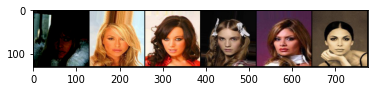

Test -  2


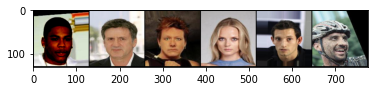

Test -  3


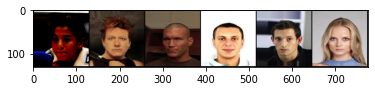

Test -  4


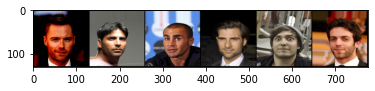

Test -  5


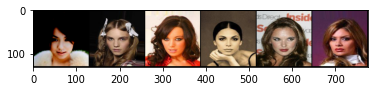

Test -  6


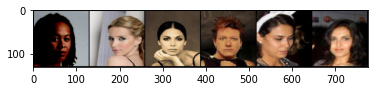

Test -  7


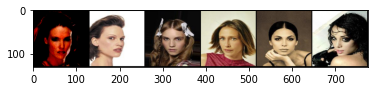

Test -  8


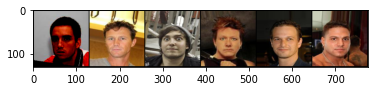

Test -  9


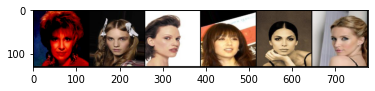

Test -  10


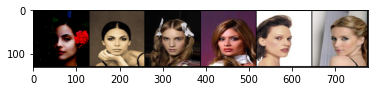

Test -  11


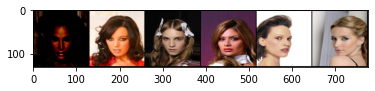

Test -  12


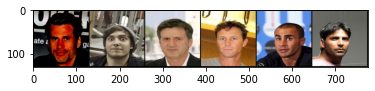

Test -  13


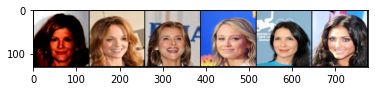

Test -  14


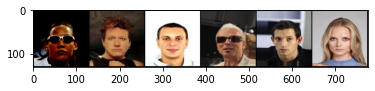

Test -  15


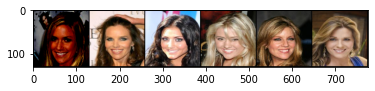

Test -  16


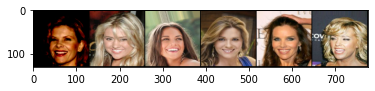

Test -  17


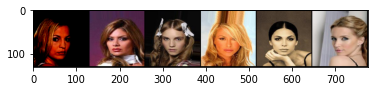

Test -  18


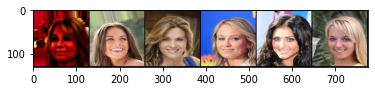

Test -  19


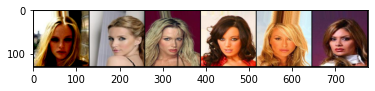

Test -  20


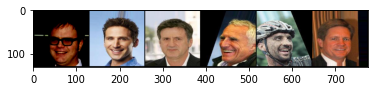

Test -  21


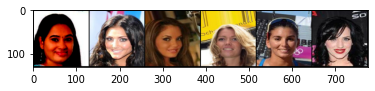

Test -  22


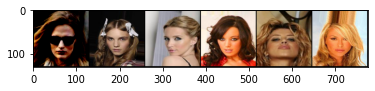

Test -  23


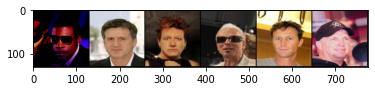

Test -  24


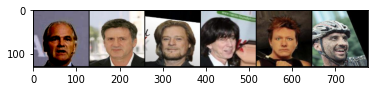

Test -  25


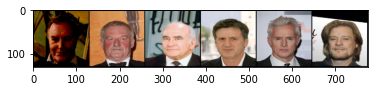

Test -  26


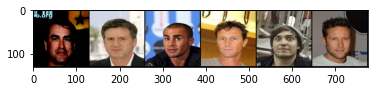

Test -  27


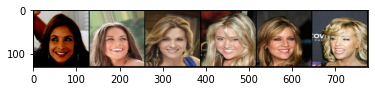

Test -  28


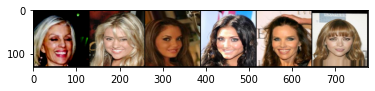

Test -  29


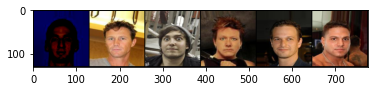

Test -  30


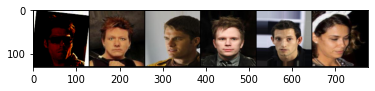

Test -  31


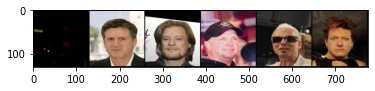

Test -  32


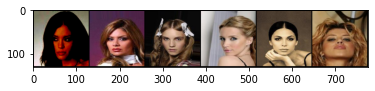

In [41]:
print(len(knn_attr) , len(knn_imgname) ,knn_attr.shape)
knn_cls.fit(knn_attr, knn_imgname)

print("First img is target , rest are the similar found")
with torch.no_grad():
  outputs = model_celeb(inputs_t)
  print("o",outputs[0].shape,len(outputs))
  attrs =  np.zeros((outputs[0].shape[0],len(outputs) ))
  print("a" , attrs.shape)
  for o in range(len(outputs)):
    _, preds = torch.max(outputs[o], 1)
    attrs[:,o] = preds
  similars = knn_cls.kneighbors(attrs,5,False)
  #print("similar" , len(similars))
  #print(similars)
  tran = transforms.ToTensor()
  tran_size = transforms.Resize((127,127))
  for s in range(len(similars)):

   #create list for display 
    imgs = [tran_size(inputs_t[s])]
    for i in range(neighbors):
      idx = similars[s][i]
      img_name = knn_imgname[idx]
      #print(img_name)
      imgs.append(tran_size(tran(Image.open(img_name).convert("RGB"))))
    sims = torchvision.utils.make_grid(imgs)
    print("Test - " , s+1)
    imshow(sims)
